In [1]:
import matplotlib.pyplot as plt
from jax.random import PRNGKey, split
import jax.numpy as jnp
import jax
from functools import partial
from tqdm import tqdm

from jax import config
config.update("jax_enable_x64", True)

from data import generate_data, generate_observation_matrix, generate_ms, forward_ms
from loss import create_loss_ms, reconstruction_loss
from network import init_net, compute_end_to_end, compute_factor, kwon_compress_network
from solver import train
from utils import compose, svd
from plot import interpolate_points

## Generating Data

In [2]:
key = PRNGKey(0)

# Simulated Data

d = 200
r = 5
m = 4000 # Number of measurements

key, subkey = split(key)
target = generate_data(key=subkey, shape=(d, d), rank=r) # True matrix

subkeys = split(key, m)
mat_sense = generate_ms(keys=subkeys, shape=(d,d), measurements=m) # Forward matrices for matrix sensing
mat_sense = jnp.asarray(mat_sense) # Saving forward matrices 

labels = (mat_sense * target).sum((-2, -1)) # Creating labels

# Creating loss functions
train_loss_fn = create_loss_ms(labels=labels, sensing_matrices=mat_sense)
test_loss_fn = reconstruction_loss(target)
loss_fn_dict = {
    'train': train_loss_fn,
    'test':  test_loss_fn
}

network_fn = compute_end_to_end

## Original Wide Network

In [3]:
depth = 3
init_scale = 1e-2

key, subkey = split(key)

# Instatiating the original wide network
init_weights = init_net(
    key=subkey, 
    input_dim=d, 
    output_dim=d, 
    width=d, 
    depth=depth, 
    init_scale=init_scale
)

tol = 1e-12
step_size = 2e1
n_outer_loops = 500
n_inner_loops = 50

In [4]:
orig_result = train(
    init_weights=init_weights,
    network_fn=network_fn,
    loss_fn_dict=loss_fn_dict,
    n_outer_loops=n_outer_loops,
    step_size=step_size,
    tol=tol,
    n_inner_loops=n_inner_loops,
    save_weights=False
)

  0%|          | 0/500 [00:00<?, ?it/s]

## Newly Compressed Network

In [5]:
# Constructing surrogate matrix
target_surrogate = mat_sense.reshape(m,-1).T @ labels
target_surrogate = jnp.reshape(target_surrogate*(1/m), (d, d))

comp_init_weights, factors = kwon_compress_network(target=target_surrogate, grad_rank=2*r, init_scale=init_scale, depth=depth)
new_comp_init_weights = [comp_init_weights[1]@comp_init_weights[0], comp_init_weights[2], comp_init_weights[4]@comp_init_weights[3]]

In [6]:
dlr = 1.0

comp_result = train(
    init_weights=new_comp_init_weights,
    network_fn=network_fn,
    loss_fn_dict=loss_fn_dict,
    n_outer_loops=n_outer_loops,
    step_size=step_size,
    dlr=dlr,
    tol=tol,
    n_inner_loops=n_inner_loops,
    save_weights=False
)

  0%|          | 0/500 [00:00<?, ?it/s]

## Plotting

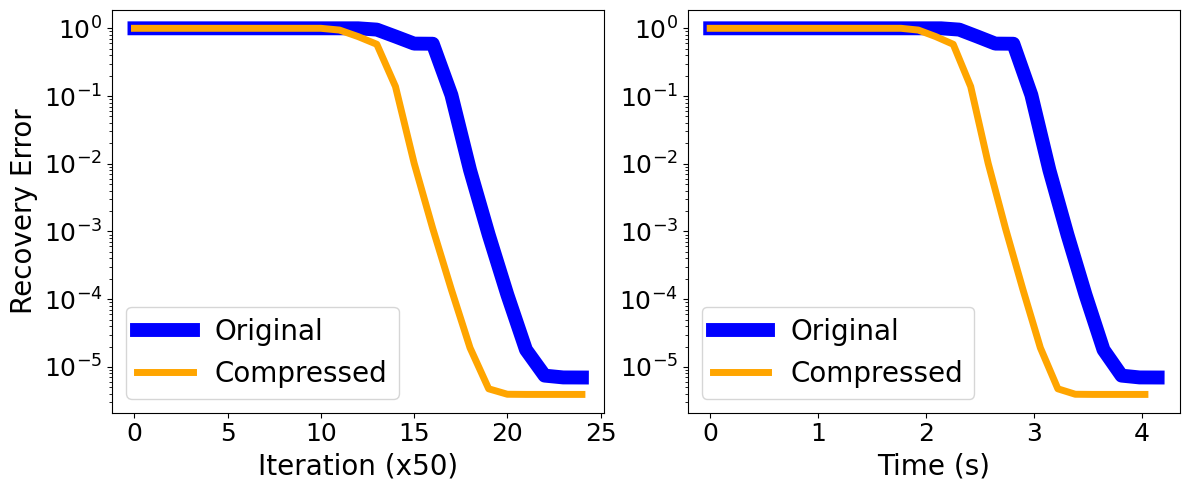

In [13]:
fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(121)

ax.semilogy(orig_result['test_loss'][:25], c='blue', linewidth=10, label='Original')
ax.semilogy(comp_result['test_loss'][:25], c='orange', linewidth=5, label='Compressed')
ax.set_xlabel(rf'Iteration (x{n_inner_loops})', fontsize=20)
ax.set_ylabel('Recovery Error', fontsize=20)
ax.legend(fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
#ax.set_title(rf'$\epsilon=${init_scale}')

ax = fig.add_subplot(122)

ax.semilogy(orig_result['time'][:25], orig_result['test_loss'][:25], c='blue', linewidth=10, label='Original')
ax.semilogy(comp_result['time'][:25], comp_result['test_loss'][:25], c='orange', linewidth=5, label='Compressed')
ax.set_xlabel(rf'Time (s)', fontsize=20)
#ax.set_ylabel('Recovery Error', fontsize=20)
ax.legend(fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
#ax.set_title(rf'$\epsilon=${init_scale}')

fig.tight_layout()

plt.savefig('figs/error_plot_ms_r5_d200.png', dpi=300, bbox_inches='tight')